In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('csv/K15T_K16_K17.csv')
df_gdp = pd.read_csv('csv/Yoy Real GDP Growth%.csv')

In [2]:
df_gdp_sg = df_gdp.loc[df_gdp['Year'].isin(list(range(2014, 2025))), ['Year', 'Singapore']]
df_gdp_sg = df_gdp_sg.rename(columns={'Singapore': 'GdpGrowth%'})
df_gdp_sg

,Year,GdpGrowth%
0,2014,3.94
1,2015,2.98
2,2016,3.75
3,2017,4.48
4,2018,3.45
5,2019,1.31
6,2020,-3.81
7,2021,9.76
8,2022,4.11
9,2023,1.82


In [3]:
# Replace spaces with underscores in column headings
df.columns = df.columns.str.replace(' ', '_')

ord_list = ['Age_Group']
cat_list = [col for col in df.columns if (df[col].dtype == 'object') and col not in ord_list]
num_list = [col for col in df.columns if df[col].dtype == 'int' or df[col].dtype == 'float' and col not in ord_list]

for col in ord_list:
    print(f'======== {col} =========')
    print(df[col].unique())

for col in cat_list:
    print(f'======== {col} =========')
    print(df[col].unique())

======== Age_Group =========
['15 - 29' '30 - 39' '40 - 49' '50 & Over']
======== Gender =========
['Male' 'Female']
======== Type =========
['Long-term' 'Short-term']
======== Occupation =========
['Associate Professionals & Technicians'
 'Managers & Administrators (Including Working Proprietors)'
 'Professionals' 'Cleaners, Labourers & Related Workers'
 'Clerical Support Workers' 'Craftsmen & Related Trades Workers' 'Others'
 'Plant & Machine Operators & Assemblers' 'Service & Sales Workers']
======== Pmet_Status =========
['PMETs' 'Non-PMETs']


In [4]:
# Handle ordinal list
Ord_dict_list = {}
for col in ord_list:
    if col in df.columns:
        Ord_elements = df[col].unique()
        Counter = 0
        mapping = {}
        for element in Ord_elements:
            mapping[element] = Counter
            Counter += 1 
        # print(mapping)
        Ord_dict_list[col] = mapping

print(Ord_dict_list)

# Encode for ordinal list
df_encoded = df.copy()
for item in Ord_dict_list:
    # print(Ord_dict_list[item])
    if item in df.columns: 
        df_encoded[f'{item}_Encoded'] = df[item].map(Ord_dict_list[item])
        df_encoded.drop(item, axis = 1, inplace= True)
        df_encoded.rename({f'{item}_Encoded' : item}, axis= 1, inplace=True)
        # print(df[f'{item}_Encoded'])

df_encoded.head()


{'Age_Group': {'15 - 29': 0, '30 - 39': 1, '40 - 49': 2, '50 & Over': 3}}


,Gender,Type,Count_(Thousands),Year,Occupation,Pmet_Status,Age_Group
0,Male,Long-term,0.286364,2014,Associate Professionals & Technicians,PMETs,0
1,Male,Short-term,1.317603,2014,Associate Professionals & Technicians,PMETs,0
2,Female,Long-term,0.000000,2014,Associate Professionals & Technicians,PMETs,0
3,Female,Short-term,1.629557,2014,Associate Professionals & Technicians,PMETs,0
4,Male,Long-term,0.182998,2014,Managers & Administrators (Including Working P...,PMETs,0


In [5]:
# Replace spaces with underscores in categorical columns
for col in cat_list:
    df_encoded[col] = df_encoded [col].str.replace(' ', '_')

# One-hot encoding for cat_list less occupation because do not want to drop first of occupation
cat_list_less_occupation = [col for col in cat_list if col != 'Occupation']
df_encoded = pd.get_dummies(df_encoded, columns=cat_list_less_occupation, drop_first=True)

# Display the encoded dataframe and properties
# print(df_encoded.head())
print(df_encoded.info())
print(df_encoded.shape)
print(df_encoded.isnull().sum().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count_(Thousands)  1584 non-null   float64
 1   Year               1584 non-null   int64  
 2   Occupation         1584 non-null   object 
 3   Age_Group          1584 non-null   int64  
 4   Gender_Male        1584 non-null   bool   
 5   Type_Short-term    1584 non-null   bool   
 6   Pmet_Status_PMETs  1584 non-null   bool   
dtypes: bool(3), float64(1), int64(2), object(1)
memory usage: 54.3+ KB
None
(1584, 7)
False


In [6]:
# encode occupation manually to drop last of occupation that is "others"
dummies = pd.get_dummies(df_encoded['Occupation'])
dummies.drop('Others', axis=1,inplace = True)
dummies

df_encoded = pd.concat([df_encoded, dummies], axis=1)
df_encoded.drop(['Occupation'], axis=1, inplace=True)
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 14 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Count_(Thousands)                                          1584 non-null   float64
 1   Year                                                       1584 non-null   int64  
 2   Age_Group                                                  1584 non-null   int64  
 3   Gender_Male                                                1584 non-null   bool   
 4   Type_Short-term                                            1584 non-null   bool   
 5   Pmet_Status_PMETs                                          1584 non-null   bool   
 6   Associate_Professionals_&_Technicians                      1584 non-null   bool   
 7   Cleaners,_Labourers_&_Related_Workers                      1584 non-null   bool   
 8   Clerical

In [7]:
# to handle fixed time effects
df_encoded = pd.get_dummies(df_encoded, columns=['Year'], drop_first=True)

# Convert all Boolean columns (True/False) to 1/0
for col in df_encoded.columns:
    if col not in num_list and col not in ord_list and col not in cat_list: 
        df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.info())
print(df_encoded.shape)
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Count_(Thousands)                                          1584 non-null   float64
 1   Age_Group                                                  1584 non-null   int64  
 2   Gender_Male                                                1584 non-null   int32  
 3   Type_Short-term                                            1584 non-null   int32  
 4   Pmet_Status_PMETs                                          1584 non-null   int32  
 5   Associate_Professionals_&_Technicians                      1584 non-null   int32  
 6   Cleaners,_Labourers_&_Related_Workers                      1584 non-null   int32  
 7   Clerical_Support_Workers                                   1584 non-null   int32  
 8   Craftsme

,Count_(Thousands),Age_Group,Gender_Male,Type_Short-term,Pmet_Status_PMETs,Associate_Professionals_&_Technicians,"Cleaners,_Labourers_&_Related_Workers",Clerical_Support_Workers,Craftsmen_&_Related_Trades_Workers,Managers_&_Administrators_(Including_Working_Proprietors),...,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024
0,0.286364,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.317603,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.629557,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.182998,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Functions

In [8]:
import statsmodels.api as sm

def pooled_linear_regression_heteroskedasticity(df, y_label):
    # Define features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label]

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit(cov_type='HC3')

    # Print the full summary of regression results
    return model.summary()

In [9]:
from statsmodels.stats.diagnostic import het_white

def residual_analysis(df, y_label):
    # model is the fitted OLS regression from statsmodels
    X = sm.add_constant(df.drop(y_label, axis=1))
    model = sm.OLS(df[y_label], X ).fit()
    residuals = model.resid

    fitted = model.fittedvalues

    plt.scatter(fitted, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    return residuals

In [10]:
# step 1: drop PMET_Status (obvious feature); re-run and check for "strong multicollinearity problems" msg
if 'Pmet_Status_PMETs' in df_encoded.columns: 
    df_encoded.drop('Pmet_Status_PMETs', axis =1 , inplace= True)

## Branch 1: 
**Interactive Dummy Variables  
Drop year and Insert GDP and lag term of GDP  
Add in polynomial term**

In [11]:
df_encoded

### Keep only the significant interaction terms and simplify the model. Possibly use regularization or selection techniques.

### Add in GDP if above failed
df_gdp_sg_indexed = df_gdp_sg.set_index('Year')
df_encoded_gdp = df_encoded.copy()

for j in range(len(df_encoded_gdp)):
    assigned = False
    for i in range(2015, 2025):
        if df_encoded_gdp.loc[j, f'Year_{i}'] == 1:
            # df_encoded_logY_interactiveDummies_gdp.at[j, 'gdpGrowth%'] = df_gdp_sg_indexed.loc[i, 'GdpGrowth%']
            df_encoded_gdp.at[j, 'gdpGrowth%'] = np.log(df_gdp_sg_indexed.loc[i, 'GdpGrowth%']/100 + 1)
            #df_encoded_gdp.at[j, 'gdpGrowth%2'] = np.log(df_gdp_sg_indexed.loc[i, 'GdpGrowth%']/100 + 1)**3
            # add lagged term
            # df_encoded_logY_interactiveDummies_gdp.at[j, 'lagGdpGrowth%'] = df_gdp_sg_indexed.loc[i-1, 'GdpGrowth%']
            df_encoded_gdp.at[j, 'lagGdpGrowth%'] = np.log(df_gdp_sg_indexed.loc[i-1, 'GdpGrowth%']/100 + 1)
            #df_encoded_gdp.at[j, 'lagGdpGrowth%2'] = np.log(df_gdp_sg_indexed.loc[i-1, 'GdpGrowth%']/100 + 1)**3
            assigned = True
    if not assigned:
        # assign GDP growth for 2014 if no year column from 2015 to 2024 was found
        # df_encoded_logY_interactiveDummies_gdp.at[j, 'gdpGrowth%'] = df_gdp_sg_indexed.loc[2014, 'GdpGrowth%']
        df_encoded_gdp.at[j, 'gdpGrowth%'] = np.log(df_gdp_sg_indexed.loc[2014, 'GdpGrowth%']/100+1)
        #df_encoded_gdp.at[j, 'gdpGrowth%2'] = np.log(df_gdp_sg_indexed.loc[2014, 'GdpGrowth%']/100 + 1)**3
        
# print(df_encoded_logY_interactiveDummies_gdp.isnull().sum())
if 'lagGdpGrowth%' in df_encoded_gdp.columns or 'lagGdpGrowth%2' in df_encoded_gdp.columns:
    df_encoded_gdp.dropna(inplace=True) #drop year 2014 for lagged term

# due to multicollinearity
for i in range(2015, 2025):
    df_encoded_gdp.drop(f'Year_{i}',axis=1,inplace=True)



In [12]:
### Add in interactive dummy variables.

from itertools import product

# print(df_encoded_gdp.columns)
# print(df['Occupation'].unique())
occup_list = [e for e in df['Occupation'].str.replace(' ', '_').unique() if e != 'Others']
binary_vars_list = ['Gender_Male', 'Type_Short-term']

df_encoded_gdp_interactiveDummies = df_encoded_gdp.copy()
for occ, binary in product(occup_list, binary_vars_list):
    # New column name to reflect the interaction term
    new_col_name = f"{occ}_x_{binary}"
    # Create interaction dummy by element-wise multiplication
    df_encoded_gdp_interactiveDummies[new_col_name] = df_encoded_gdp[occ] * df_encoded_gdp[binary]

df_encoded_gdp_interactiveDummies.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 144 to 1583
Data columns (total 30 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Count_(Thousands)                                                            1440 non-null   float64
 1   Age_Group                                                                    1440 non-null   int64  
 2   Gender_Male                                                                  1440 non-null   int32  
 3   Type_Short-term                                                              1440 non-null   int32  
 4   Associate_Professionals_&_Technicians                                        1440 non-null   int32  
 5   Cleaners,_Labourers_&_Related_Workers                                        1440 non-null   int32  
 6   Clerical_Support_Workers                   

In [13]:
#Add in polynomial term for age_group
df_encoded_gdp_interactiveDummies_poly = df_encoded_gdp_interactiveDummies.copy()
mean_age_grp = df_encoded_gdp_interactiveDummies_poly.Age_Group.mean()

# to mitigate structural collinearity use (x - x_mean) and (x - x_mean) square
df_encoded_gdp_interactiveDummies_poly['age_centred'] = df_encoded_gdp_interactiveDummies_poly.Age_Group - mean_age_grp
df_encoded_gdp_interactiveDummies_poly['age_centred_sq'] = (df_encoded_gdp_interactiveDummies_poly.Age_Group - mean_age_grp)**2
df_encoded_gdp_interactiveDummies_poly.drop('Age_Group', axis = 1, inplace = True)


In [14]:
pooled_linear_regression_heteroskedasticity(df_encoded_gdp_interactiveDummies_poly, 'Count_(Thousands)')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Count_(Thousands)   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     67.41
Date:                Sun, 14 Sep 2025   Prob (F-statistic):          2.88e-247
Time:                        02:07:57   Log-Likelihood:                -977.71
No. Observations:                1440   AIC:                             2017.
Df Residuals:                    1409   BIC:                             2181.
Df Model:                          30                                         
Covariance Type:                  HC3                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
const                                                                          -0.0617      0.034     -1.814      0.070      -0.128       0.005
Gender_Male                                                                     0.0297      0.023      1.308      0.191      -0.015       0.074
Type_Short-term                                                                 0.0216      0.023      0.951      0.342      -0.023       0.066
Associate_Professionals_&_Technicians                                           0.4114      0.079      5.200      0.000       0.256       0.566
Cleaners,_Labourers_&_Related_Workers                                           0.0921      0.040      2.278      0.023       0.013       0.171
Clerical_Support_Workers                                                        0.6521      0.086      7.603      0.000       0.484       0.820
Craftsmen_&_Related_Trades_Workers                                             -0.0456      0.032     -1.435      0.151      -0.108       0.017
Managers_&_Administrators_(Including_Working_Proprietors)                       0.1214      0.060      2.020      0.043       0.004       0.239
Plant_&_Machine_Operators_&_Assemblers                                         -0.1244      0.046     -2.688      0.007      -0.215      -0.034
Professionals                                                                   0.3749      0.078      4.790      0.000       0.221       0.528
Service_&_Sales_Workers                                                         0.3724      0.076      4.901      0.000       0.223       0.521
gdpGrowth%                                                                     -1.1688      0.518     -2.257      0.024      -2.184      -0.154
lagGdpGrowth%                                                                  -1.6317      0.432     -3.775      0.000      -2.479      -0.785
Associate_Professionals_&_Technicians_x_Gender_Male                             0.0578      0.098      0.589      0.556      -0.135       0.250
Associate_Professionals_&_Technicians_x_Type_Short-term                         1.0286      0.098     10.469      0.000       0.836       1.221
Managers_&_Administrators_(Including_Working_Proprietors)_x_Gender_Male         0.2991      0.071      4.220      0.000       0.160       0.438
Managers_&_Administrators_(Including_Working_Proprietors)_x_Type_Short-term     0.6112      0.071      8.624      0.000       0.472       0.750
Professionals_x_Gender_Male                                                     0.0716      0.099      0.722      0.470      -0.123       0.266
Professionals_x_Type_Short-term                            

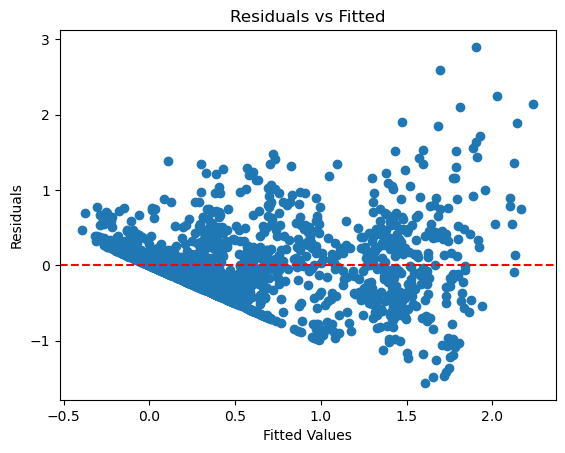

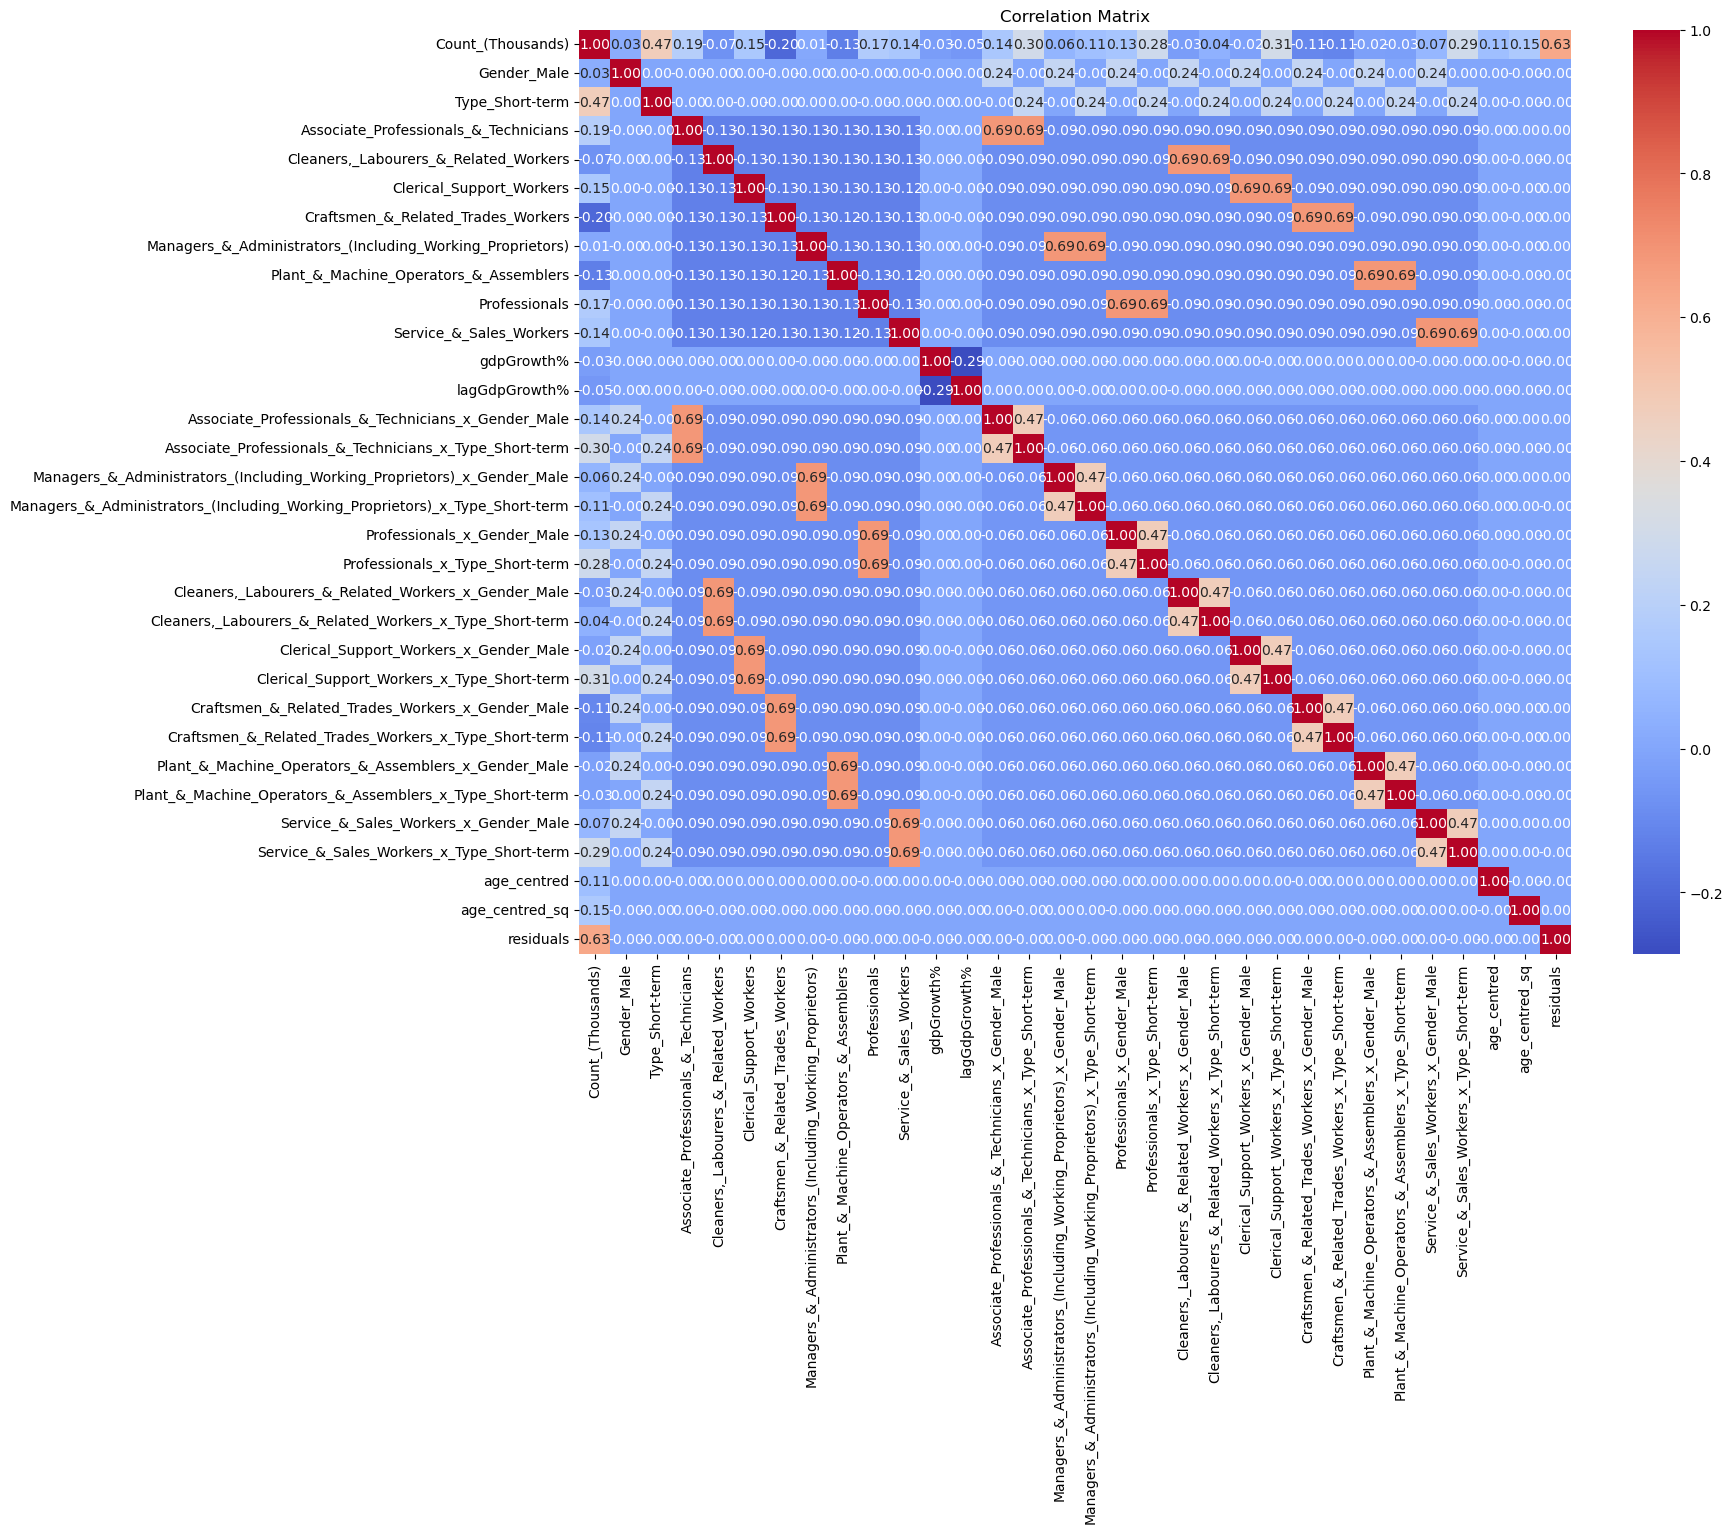

In [15]:
residuals = residual_analysis(df_encoded_gdp_interactiveDummies_poly, 'Count_(Thousands)')
df_residual = df_encoded_gdp_interactiveDummies_poly.copy()
df_residual['residuals'] = residuals
df_residual.head(3)

corr_matrix = df_residual.corr(numeric_only=True)  
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

## rename column names due to syntax errors in statsmodels formulas from special characters or spaces
# print(df_encoded_gdp_interactiveDummies_poly.columns)
df_poisson = df_encoded_gdp_interactiveDummies_poly.copy()
df_poisson.rename(columns=lambda x: x.lower()
                          .replace('%', '_pct')
                          .replace('&', 'and')
                          .replace(',', '')
                          .replace('(', '')
                          .replace(')', '')
                          .replace('-', '_')
                          .replace(' ', '_'),
          inplace=True)

# print(df_poisson.columns)

y_label = 'count_thousands'
formula = f'{y_label} ~ '
for i, col in enumerate(df_poisson.columns):
    if col != 'count_thousands':
        if i != len(df_poisson.columns) -1:
            formula += col + ' + '
        else:
            formula += col
# print(formula)

# Fit Poisson regression
poisson_model = smf.glm(formula=formula, data=df_poisson, family=sm.families.Poisson()).fit(cov_type='HC3')

# Print the summary
poisson_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        count_thousands   No. Observations:                 1440
Model:                            GLM   Df Residuals:                     1409
Model Family:                 Poisson   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -989.62
Date:                Sun, 14 Sep 2025   Deviance:                       440.47
Time:                        02:07:58   Pearson chi2:                     432.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4496
Covariance Type:                  HC3                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      -5.9420      0.285    -20.877      0.000      -6.500      -5.384
gender_male                                                                     1.7622      0.235      7.494      0.000       1.301       2.223
type_short_term                                                                 1.1365      0.264      4.302      0.000       0.619       1.654
associate_professionals_and_technicians                                         4.9704      0.318     15.610      0.000       4.346       5.594
cleaners_labourers_and_related_workers                                          3.7070      0.331     11.185      0.000       3.057       4.357
clerical_support_workers                                                        4.8480      0.321     15.121      0.000       4.220       5.476
craftsmen_and_related_trades_workers                                            1.5868      0.368      4.307      0.000       0.865       2.309
managers_and_administrators_including_working_proprietors                       4.2228      0.333     12.684      0.000       3.570       4.875
plant_and_machine_operators_and_assemblers                                      1.9991      0.390      5.120      0.000       1.234       2.764
professionals                                                                   4.8928      0.321     15.254      0.000       4.264       5.521
service_and_sales_workers                                                       4.6346      0.331     14.003      0.000       3.986       5.283
gdpgrowth_pct                                                                  -1.9554      0.687     -2.846      0.004      -3.302      -0.609
laggdpgrowth_pct                                                               -2.8889      0.712     -4.057      0.000      -4.285      -1.493
associate_professionals_and_technicians_x_gender_male                          -1.6725      0.257     -6.498      0.000      -2.177      -1.168
associate_professionals_and_technicians_x_type_short_term                       0.0667      0.305      0.219      0.827      -0.531       0.665
managers_and_administrators_including_working_proprietors_x_gender_male        -1.1975      0.268     -4.472      0.000      -1.722      -0.673
managers_and_administrators_including_working_proprietors_x_type_short_term     0.0425      0.303      0.140      0.888      -0.551       0.636
professionals_x_gender_male                                                    -1.6544      0.259     -6.385      0.000      -2.162      -1.147
professionals_x_type_short_term                            

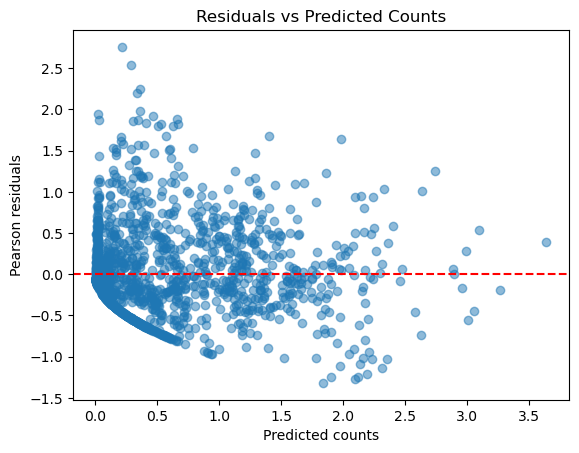

In [17]:
# Access residuals
# deviance_resid = poisson_model.resid_deviance
# pearson_resid = poisson_model.resid_pearson
# response_resid = poisson_model.resid_response
# working_resid = poisson_model.resid_working

# print("Deviance Residuals:\n", deviance_resid)
# print("Pearson Residuals:\n", pearson_resid)
# print("Response Residuals:\n", response_resid)
# print("Working Residuals:\n", working_resid)

# Predicted count values
y_pred = poisson_model.fittedvalues

# Pearson residuals (recommended)
residuals = poisson_model.resid_pearson

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted counts')
plt.ylabel('Pearson residuals')
plt.title('Residuals vs Predicted Counts')
plt.show()


In [18]:
print(poisson_model.aic, poisson_model.bic, poisson_model.bic_llf)

# Check overdispersion ratio (Poisson)
overdispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
print(f"Overdispersion ratio: {overdispersion:.2f}")

2041.2311380764709 -9806.336850313732 2204.6754882461423
Overdispersion ratio: 0.31


c:\Users\user\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [19]:
nb_model = smf.glm(formula=formula, data=df_poisson, family=sm.families.NegativeBinomial()).fit(cov_type='HC3')
print("Negative Binomial AIC:", nb_model.aic)
print("Negative Binomial BIC:", nb_model.bic_llf)
nb_model.summary()



c:\Users\user\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Negative Binomial AIC: 2482.199199297214
Negative Binomial BIC: 2645.6435494668854


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        count_thousands   No. Observations:                 1440
Model:                            GLM   Df Residuals:                     1409
Model Family:        NegativeBinomial   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1210.1
Date:                Sun, 14 Sep 2025   Deviance:                       299.55
Time:                        02:07:59   Pearson chi2:                     276.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3200
Covariance Type:                  HC3                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      -5.9845      0.281    -21.275      0.000      -6.536      -5.433
gender_male                                                                     1.7584      0.232      7.569      0.000       1.303       2.214
type_short_term                                                                 1.1342      0.258      4.389      0.000       0.628       1.641
associate_professionals_and_technicians                                         4.8669      0.320     15.232      0.000       4.241       5.493
cleaners_labourers_and_related_workers                                          3.6926      0.325     11.348      0.000       3.055       4.330
clerical_support_workers                                                        4.8236      0.315     15.293      0.000       4.205       5.442
craftsmen_and_related_trades_workers                                            1.6578      0.365      4.545      0.000       0.943       2.373
managers_and_administrators_including_working_proprietors                       4.2698      0.327     13.054      0.000       3.629       4.911
plant_and_machine_operators_and_assemblers                                      2.1721      0.387      5.610      0.000       1.413       2.931
professionals                                                                   4.7885      0.323     14.813      0.000       4.155       5.422
service_and_sales_workers                                                       4.5309      0.325     13.946      0.000       3.894       5.168
gdpgrowth_pct                                                                  -1.5982      0.706     -2.265      0.023      -2.981      -0.215
laggdpgrowth_pct                                                               -2.8660      0.724     -3.961      0.000      -4.284      -1.448
associate_professionals_and_technicians_x_gender_male                          -1.5316      0.261     -5.869      0.000      -2.043      -1.020
associate_professionals_and_technicians_x_type_short_term                       0.1587      0.298      0.533      0.594      -0.425       0.742
managers_and_administrators_including_working_proprietors_x_gender_male        -1.2537      0.267     -4.689      0.000      -1.778      -0.730
managers_and_administrators_including_working_proprietors_x_type_short_term     0.0677      0.298      0.227      0.820      -0.516       0.652
professionals_x_gender_male                                                    -1.5139      0.263     -5.755      0.000      -2.029      -0.998
professionals_x_type_short_term                            

In [20]:
# Poisson is better:
## lower AIC/BIC
## overdispersion = 0.31 meaning underdispersion - favor Poisson over Negative Binomial
## Better Pseudo R-squ. (CS)